In [1]:
%pylab inline
%config InlineBackend.figure_format = 'svg'

Populating the interactive namespace from numpy and matplotlib


In [2]:
import arviz as az
import astropy.cosmology as cosmo
from astropy.cosmology import Planck15
import astropy.units as u
import corner
import emcee
import glob
import h5py
import multiprocessing as multi
import pandas as pd
import pystan
from scipy.interpolate import interp1d
from scipy.optimize import fmin_powell
import scipy.stats as ss
import seaborn as sns
from tqdm import tqdm_notebook
import warnings

sns.set_style('ticks')
sns.set_context('notebook')
sns.set_palette('colorblind')

The models in this notebook imagine that the *conditional* distribution for $\left. \chi_\mathrm{eff} \mid m_1 \right.$ follows
$$
p\left( \chi_\mathrm{eff} | m_1 \right) \propto N\left[ \mu_0 + \alpha \left( \frac{m_1}{30 \, M_\odot} - 1 \right), \sigma_0 \exp\left( \beta \left( \frac{m_1}{30 \, M_\odot} - 1 \right)\right) \right]\left( \chi_\mathrm{eff} \right),
$$
where $N\left[ \mu, \sigma \right](x)$ is a normal probability density with mean $\mu$ and s.d. $\sigma$ evaluated at $x$.

## GWTC-1

What happens if we apply this to GWTC-1?

In [3]:
zs_interp = expm1(linspace(log(1), log(2+1), 1000))
ds_interp = Planck15.luminosity_distance(zs_interp).to(u.Mpc).value
z_of_d = interp1d(ds_interp, zs_interp)

names = []
posts = []
for fn in tqdm_notebook(glob.glob('GWTC-1/*.hdf5')):
    with h5py.File(fn, 'r') as f:
        ds = array(f['Overall_posterior']['luminosity_distance_Mpc'])
        z = z_of_d(ds)
        m1 = array(f['Overall_posterior']['m1_detector_frame_Msun'])/(1+z)
        m2 = array(f['Overall_posterior']['m2_detector_frame_Msun'])/(1+z)
        ct1 = array(f['Overall_posterior']['costilt1'])
        ct2 = array(f['Overall_posterior']['costilt2'])
        a1 = array(f['Overall_posterior']['spin1'])
        a2 = array(f['Overall_posterior']['spin2'])
        chi_eff = (m1*a1*ct1 + m2*a2*ct2)/(m1+m2)
        posts.append(pd.DataFrame({'m1': m1, 'm2': m2, 'z': z, 'chi_eff': chi_eff}))
        names.append(fn)

In [4]:
def simulate_chi_eff_prior(size=1):
    mas = np.random.uniform(size=size)
    mbs = np.random.uniform(size=size)
    m1s = where(mas > mbs, mas, mbs)
    m2s = where(mas > mbs, mbs, mas)
    
    ct1s = np.random.uniform(low=-1, high=1, size=size)
    ct2s = np.random.uniform(low=-1, high=1, size=size)
    
    a1s = np.random.uniform(size=size)
    a2s = np.random.uniform(size=size)
    
    return (m1s*ct1s*a1s + m2s*ct2s*a2s)/(m1s+m2s)

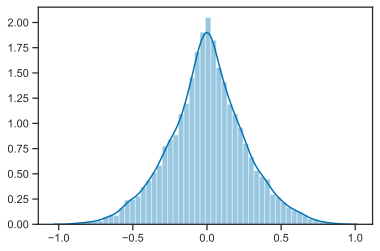

In [5]:
sns.distplot(simulate_chi_eff_prior(10000))

In [6]:
chi_effs_prior = simulate_chi_eff_prior(10000)
approx_chi_eff_li_prior = ss.gaussian_kde(chi_effs_prior)

In [7]:
def li_prior_wt(z, chieff):
    return (1+z)**2*Planck15.luminosity_distance(z).to(u.Mpc).value**2*(Planck15.comoving_distance(z).to(u.Mpc).value + (1+z)*Planck15.hubble_distance.to(u.Mpc).value / Planck15.efunc(z))*approx_chi_eff_li_prior(chieff)

In [8]:
for p in tqdm_notebook(posts):
    p['li_prior_wt'] = li_prior_wt(p['z'], p['chi_eff'])

In [9]:
MMin = 5
def pop_prior_wt(m1, m2, z):
    return 1.0/m1/(m1-MMin)*(1+z)**1.7*Planck15.differential_comoving_volume(z).to(u.Mpc**3/u.sr).value*4*pi

In [10]:
for p in posts:
    p['pop_prior_wt'] = pop_prior_wt(p['m1'], p['m2'], p['z'].values)

Neff = 240
Neff = 20406
Neff = 1522
Neff = 436
Neff = 3258
Neff = 13667
Neff = 993
Neff = 556
Neff = 2220
Neff = 428


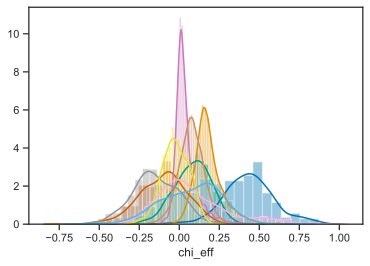

In [11]:
likelihoods = []
for p in posts:
    wts = p['pop_prior_wt']/p['li_prior_wt']
    rs = np.random.uniform(low=0, high=np.max(wts), size=len(wts))
    s = rs < wts
    sns.distplot(p['chi_eff'][s])
    likelihoods.append(p[s])
for l in likelihoods:
    print('Neff = {:d}'.format(len(l)))

In [12]:
with h5py.File('design-selected.h5', 'r') as f:
    chi_eff_sel = array(f['chi_effs'])
    m1_sel = array(f['m1s'])
    N_draw = f.attrs['N_draw']

In [18]:
sel_thin = 5
Nsamp = 15
chiel = []
m1l = []
bw_chi = []
for l in likelihoods:
    c = np.random.choice(len(l), size=Nsamp, replace=False)
    lc = l.iloc[c]
    chiel.append(lc['chi_eff'].to_numpy())
    m1l.append(lc['m1'].to_numpy())
    bw_chi.append(std(chiel[-1])/Nsamp**0.2)

In [19]:
model = pystan.StanModel(file='chi_eff_running.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_4d263c9e51842f17ba2b99a0b64b2165 NOW.
/Users/wfarr/anaconda3/envs/chieffregression/lib/python3.7/site-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/35/vcq24mtj2_g5wk96mbck0cw400018s/T/tmp0rmx3e5x/stanfit4anon_model_4d263c9e51842f17ba2b99a0b64b2165_8559855702249802041.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [20]:
data = {
    'Nobs': len(chiel),
    'Nsamp': len(chiel[0]),
    'chi_eff': chiel,
    'm1': m1l,
    'chi_eff_bw': bw_chi,
    
    'Nsel': len(chi_eff_sel[::sel_thin]),
    'Ndraw': N_draw,
    'chi_eff_sel': chi_eff_sel[::sel_thin],
    'm1_sel': m1_sel[::sel_thin],
    'log_sel_wt': log(0.5)*ones_like(chi_eff_sel[::sel_thin]),
    
    'mlow': 5,
    'mhigh': 100,
    'sigma_min': 0.05
}

In [21]:
samples = model.sampling(data=data)
asamples = az.convert_to_inference_data(samples)

In [22]:
az.ess(asamples, var_names=['mu0', 'sigma0', 'alpha', 'beta'])

<xarray.Dataset>
Dimensions:  ()
Data variables:
    mu0      float64 3.629e+03
    sigma0   float64 2.812e+03
    alpha    float64 1.597e+03
    beta     float64 2.49e+03

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1244717b8>,
      dtype=object)

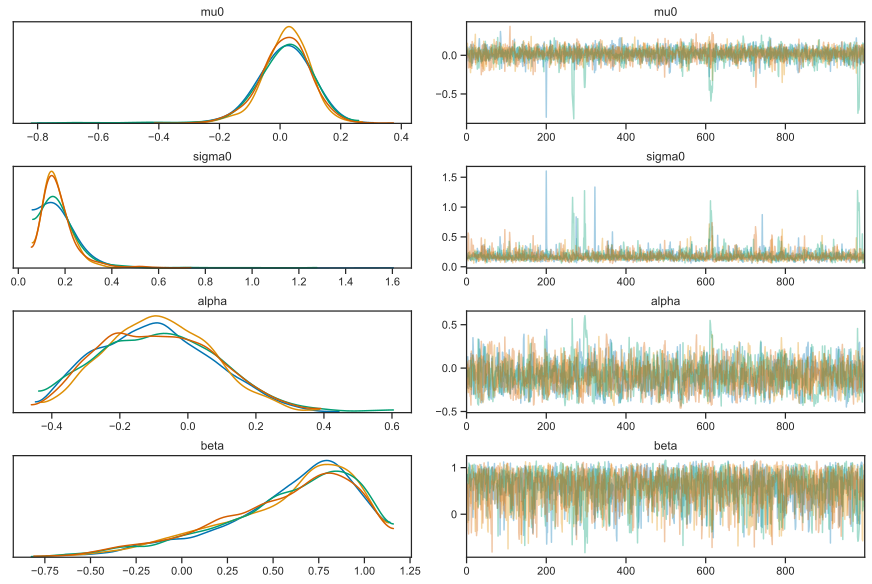

In [23]:
az.plot_trace(asamples, var_names=['mu0', 'sigma0', 'alpha', 'beta'])

In [24]:
az.plot_posterior(asamples, var_names=['mu0', 'sigma0', 'alpha', 'beta'], credible_interval=0.68)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x124dc14a8>,
      dtype=object)

In [25]:
az.plot_pair(asamples, var_names=['mu0', 'sigma0', 'alpha', 'beta'], divergences=True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x125882278>,
      dtype=object)

In [26]:
CHIS, MS = meshgrid(linspace(-1, 1, 100), logspace(log10(5), log10(100), 100), indexing='ij')
PCHIS = zeros_like(CHIS)
for mu0, sigma0, alpha, beta in zip(*[asamples.posterior[k].values.flatten() for k in ['mu0', 'sigma0', 'alpha', 'beta']]):
    dist = ss.norm(loc=mu0+alpha*(MS/30-1), scale=sigma0*exp(beta*(MS/30-1)))
    PCHIS += dist.pdf(CHIS)/(dist.cdf(1) - dist.cdf(-1))
PCHIS /= len(asamples.posterior.mu0.values.flatten())

Text(0, 0.5, '$m_1$ ($M_\\odot$)')

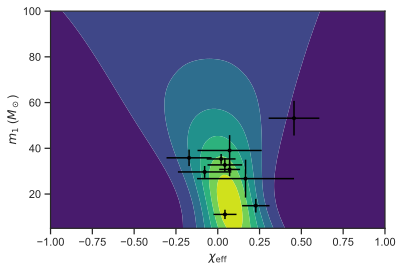

In [27]:
contourf(CHIS, MS, PCHIS, cmap='viridis', vmin=0)
for ce, m in zip(chiel, m1l):
    errorbar(mean(ce), mean(m), yerr=std(m), xerr=std(ce), fmt='.', color='k')
xlabel(r'$\chi_\mathrm{eff}$')
ylabel(r'$m_1$ ($M_\odot$)')

In [28]:
az.to_netcdf(asamples, 'pop-samples-running.nc')

'pop-samples-running.nc'

What if we leave off the most massive?

In [29]:
data_no170729 = data.copy()
imax = argmax([mean(m) for m in data_no170729['m1']])
data_no170729['Nobs'] -= 1
data_no170729['m1'] = data_no170729['m1'].copy()
data_no170729['m1'].pop(imax)
data_no170729['chi_eff'] = data_no170729['chi_eff'].copy()
data_no170729['chi_eff'].pop(imax)
data_no170729['chi_eff_bw'] = data_no170729['chi_eff_bw'].copy()
data_no170729['chi_eff_bw'].pop(imax)
imax, mean(data['m1'][imax]), names[imax]

(0, 53.158561903927556, 'GWTC-1/GW170729_GWTC-1.hdf5')

In [30]:
samples_no170729 = model.sampling(data=data_no170729)
asamples_no170729 = az.convert_to_inference_data(samples_no170729)

/Users/wfarr/anaconda3/envs/chieffregression/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x124318e10>,
      dtype=object)

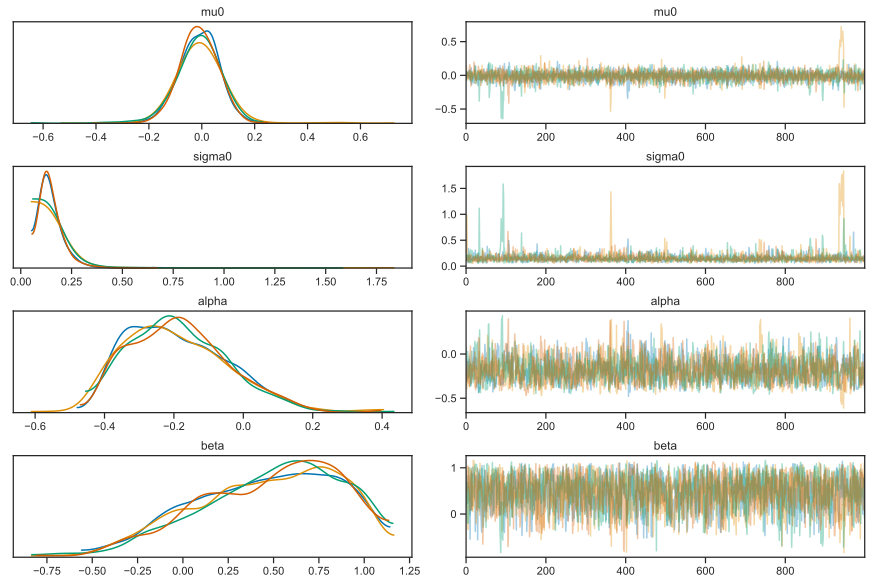

In [31]:
az.plot_trace(asamples_no170729, var_names=['mu0', 'sigma0', 'alpha', 'beta'])

In [32]:
PCHIS_NO170729 = zeros_like(CHIS)
for mu0, sigma0, alpha, beta in zip(*[asamples_no170729.posterior[k].values.flatten() for k in ['mu0', 'sigma0', 'alpha', 'beta']]):
    dist = ss.norm(loc=mu0+alpha*(MS/30-1), scale=sigma0*exp(beta*(MS/30-1)))
    PCHIS_NO170729 += dist.pdf(CHIS)/(dist.cdf(1) - dist.cdf(-1))
PCHIS_NO170729 /= len(asamples_no170729.posterior.mu0.values.flatten())

Text(0, 0.5, '$m_1$ ($M_\\odot$)')

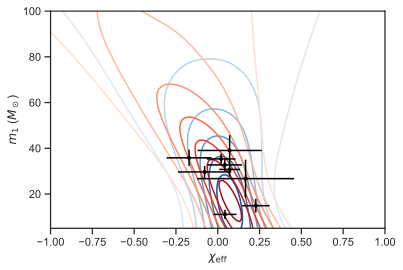

In [33]:
contour(CHIS, MS, PCHIS, cmap='Blues', vmin=0)
contour(CHIS, MS, PCHIS_NO170729, cmap='Reds', vmin=0)
for ce, m in zip(data_no170729['chi_eff'], data_no170729['m1']):
    errorbar(mean(ce), mean(m), yerr=std(m), xerr=std(ce), fmt='.', color='k')
xlabel(r'$\chi_\mathrm{eff}$')
ylabel(r'$m_1$ ($M_\odot$)')

In [34]:
az.to_netcdf(asamples_no170729, 'pop-samples-running-no170729.nc')

'pop-samples-running-no170729.nc'

## How About a Forecast

Let's draw some samples from the detected distribution of sources weighted by a reasonable parameterization of the $\chi_\mathrm{eff}$ distribution:

In [35]:
with h5py.File('design-selected.h5', 'r') as f:
    chi_eff_sel = array(f['chi_effs'])
    m1_sel = array(f['m1s'])
    snr_sel = array(f['snrs'])
    N_draw = f.attrs['N_draw']

In [36]:
mu0_true = 0.0
sigma0_true = 0.1
alpha_true = -0.2
beta_true = 0.5

In [37]:
rstate = np.random.get_state()
try:
    np.random.seed(1101286916)

    wts_true = ss.norm(loc=mu0_true + alpha_true*(m1_sel/30-1), scale=sigma0_true*exp(beta_true*(m1_sel/30-1))).pdf(chi_eff_sel)
    wts_true /= np.sum(wts_true)

    Nforecast = 100
    ind = np.random.choice(len(chi_eff_sel), Nforecast, replace=False, p=wts_true)

    chi_eff_forecast_true = chi_eff_sel[ind]
    m1_forecast_true = m1_sel[ind]
    snr_forecast_true = snr_sel[ind]
finally:
    np.random.set_state(rstate)
    
scatter(chi_eff_forecast_true, m1_forecast_true)
xlabel(r'$\chi_\mathrm{eff}$')
ylabel(r'$m_1$ ($M_\odot$)')

Text(0, 0.5, '$m_1$ ($M_\\odot$)')

In [38]:
chi_eff_forecast_like = []
m1_forecast_like = []
chi_eff_forecast_bandwidth = []

sigma_ce0 = 0.3
sigma_m0 = 10.0
snr_thresh = 8*sqrt(2)

Nsamp = 15

for ce, m, sn in zip(chi_eff_forecast_true, m1_forecast_true, snr_forecast_true):
    sigma_ce = sigma_ce0*snr_thresh/sn
    sigma_m = sigma_m0*snr_thresh/sn
    
    ceo = -2.0
    mo = -1.0
    while abs(ceo) > 1 or mo < 0:
        ceo = ce + sigma_ce*randn()
        mo = m + sigma_m*randn()
        
    ces = ceo + sigma_ce*randn(Nsamp*10)
    m1s = mo + sigma_m*randn(Nsamp*10)
    
    sel = (abs(ces) < 1) & (m1s > 0)
    ces = ces[sel]
    m1s = m1s[sel]
    
    c = np.random.choice(len(m1s), Nsamp, replace=False)
    chi_eff_forecast_like.append(ces[c])
    m1_forecast_like.append(m1s[c])
    chi_eff_forecast_bandwidth.append(std(chi_eff_forecast_like[-1])/Nsamp**(1.0/5.0))
    
chi_eff_forecast_like = array(chi_eff_forecast_like)
m1_forecast_like = array(m1_forecast_like)
chi_eff_forecast_bandwidth = array(chi_eff_forecast_bandwidth)

errorbar(mean(chi_eff_forecast_like, axis=1), mean(m1_forecast_like, axis=1), xerr=std(chi_eff_forecast_like, axis=1), yerr=std(m1_forecast_like, axis=1), fmt='.')
xlabel(r'$\chi_\mathrm{eff}$')
ylabel(r'$m_1$ ($M_\odot$)')

Text(0, 0.5, '$m_1$ ($M_\\odot$)')

In [39]:
sel_thin = 4

data_forecast = {
    'Nobs': Nforecast,
    'Nsamp': Nsamp,
    'chi_eff': chi_eff_forecast_like,
    'chi_eff_bw': chi_eff_forecast_bandwidth,
    'm1': m1_forecast_like,
    
    'Ndraw': int(round(N_draw/float(sel_thin))),
    'Nsel': len(chi_eff_sel[::sel_thin]),
    'chi_eff_sel': chi_eff_sel[::sel_thin],
    'm1_sel': m1_sel[::sel_thin],
    'log_sel_wt': log(0.5)*ones_like(m1_sel[::sel_thin]),
    
    'mlow': 5,
    'mhigh': 100,
    'sigma_min': 0.05
}

In [40]:
samples_forecast = model.sampling(data=data_forecast)
asamples_forecast = az.convert_to_inference_data(samples_forecast)

/Users/wfarr/anaconda3/envs/chieffregression/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [41]:
az.ess(asamples_forecast, var_names=['mu0', 'sigma0', 'alpha', 'beta'])

<xarray.Dataset>
Dimensions:  ()
Data variables:
    mu0      float64 2.57e+03
    sigma0   float64 2.62e+03
    alpha    float64 1.245e+03
    beta     float64 1.561e+03

In [42]:
az.plot_trace(asamples_forecast, var_names=['mu0', 'sigma0', 'alpha', 'beta'], lines=[('mu0', {}, mu0_true),
                                                                                      ('sigma0', {}, sigma0_true),
                                                                                      ('alpha', {}, alpha_true),
                                                                                      ('beta', {}, beta_true)])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1236be470>,
      dtype=object)

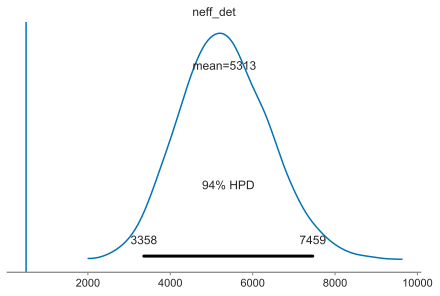

In [43]:
az.plot_posterior(asamples_forecast, var_names='neff_det')
axvline(5*len(chi_eff_forecast_true))

In [44]:
CHIS, MS = meshgrid(linspace(-1, 1, 100), logspace(log10(5), log10(100), 100), indexing='ij')
PCHIS = zeros_like(CHIS)
for mu0, sigma0, alpha, beta in zip(*[asamples_forecast.posterior[k].values.flatten() for k in ['mu0', 'sigma0', 'alpha', 'beta']]):
    dist = ss.norm(loc=mu0+alpha*(MS/30-1), scale=sigma0*exp(beta*(MS/30-1)))
    PCHIS += dist.pdf(CHIS)/(dist.cdf(1) - dist.cdf(-1))
PCHIS /= len(asamples_forecast.posterior.mu0.values.flatten())

In [45]:
contour(CHIS, MS, PCHIS, cmap='Greens', vmin=0, levels=10)
for ce, m in zip(data_forecast['chi_eff'], data_forecast['m1']):
    errorbar(mean(ce), mean(m), yerr=std(m), xerr=std(ce), fmt='.', color=sns.color_palette()[0], alpha=0.25)
scatter(chi_eff_forecast_true, m1_forecast_true, color='k')
xlabel(r'$\chi_\mathrm{eff}$')
ylabel(r'$m_1$ ($M_\odot$)')
axis(ymin=5)

(-1.0, 1.0, 5, 100.0)

In [46]:
az.to_netcdf(asamples_forecast, 'pop-samples-running-forecast.nc')

'pop-samples-running-forecast.nc'